In [1]:
# use kernel/conda env called "oliviaJupyter" 
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal
from datetime import datetime
import imageio
from scipy.ndimage import gaussian_filter, uniform_filter
%matplotlib  widget

In [2]:
workdir = '/data/ocp4/LagunaSalada/Data_and_Figs/'
cropdir = 'cropped_9000_1800_18000_3600/'
dates = [os.path.basename(x) for x in glob.glob(workdir+cropdir+"SLC_vv/2*")]
dates=sorted(dates)
nd=len(dates) #nd is 211 as of 5-19-22

# for the entire region 
x1=0; y1=0; x2=18000; y2=3600
#dx=10000
dx=x2-x1
#dy=1780
dy=y2-y1

# for smaller region with interesting TPC feature
#x1=8000; x2=11000; y1=1100; y2=1800
#dx=x2-x1
#dy=y2-y1

# load precip data
precip = np.loadtxt('/data/ocp4/LagunaSalada/3_precip/precip_2days.txt') # still in inches
# convert to cm from inches 
precip = precip*2.54

# make the dates from precip.txt into datetime objects
slc_dates=[]
for i in range(0,len(dates)):
    slc_dates.append(datetime.strptime(str(dates[i]).replace('\n',''), '%Y%m%d'))
    
#print(len(dates[0:-1]))
#print(type(slc_dates[-1]))

<br>This is where I found the info: 

documentation: https://imageio.readthedocs.io/en/stable/examples.html <br>
change frame rate: https://stackoverflow.com/questions/38433425/custom-frame-duration-for-animated-gif-in-python-imageio

In [3]:
# just plot TPC map to edit figure (before making gif)
# load 3 slcs
i=0 # this tells it which TPC map to plot as a test 
# load in the 3 SLCs 
ds = gdal.Open(workdir+"/"+cropdir+"/SLC_vv/"+dates[i]+"/"+dates[i]+".slc.full", \
                gdal.GA_ReadOnly)
slc1 = ds.GetRasterBand(1).ReadAsArray(x1,y1,dx,dy)
ds = gdal.Open(workdir+"/"+cropdir+"/SLC_vv/"+dates[i+1]+"/"+dates[i+1]+".slc.full", \
                gdal.GA_ReadOnly)
slc2 = ds.GetRasterBand(1).ReadAsArray(x1,y1,dx,dy)
ds = gdal.Open(workdir+"/"+cropdir+"/SLC_vv/"+dates[i+2]+"/"+dates[i+2]+".slc.full", \
                gdal.GA_ReadOnly)
slc3 = ds.GetRasterBand(1).ReadAsArray(x1,y1,dx,dy)

# 3 SLCs, can make 2 sequential igrams
int12 = slc1 * np.conj(slc2)
int23 = slc2 * np.conj(slc3)
int31 = slc3 * np.conj(slc1)
# normalizing, didn't change anything 
int12 = np.exp(1j*np.angle(int12))
int23 = np.exp(1j*np.angle(int23))
int31 = np.exp(1j*np.angle(int31))
# now filter them by alooks/rlooks 
alooks=40; rlooks=200
int12filt = uniform_filter((int12), size=[alooks,rlooks])
int23filt = uniform_filter((int23), size=[alooks,rlooks])
int31filt = uniform_filter((int31), size=[alooks,rlooks])
# calculate tpc
tpc = np.angle(int12filt*int23filt*int31filt)

In [4]:
print(np.shape(tpc))
print(type(tpc[0,0]))

(3600, 18000)
<class 'numpy.float32'>


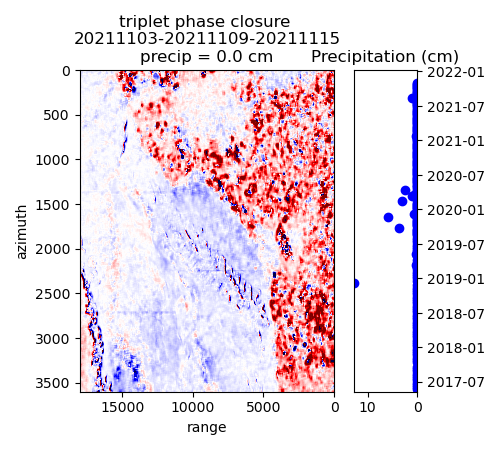

In [5]:
# plot single TPC map
i=200 # this tells it what igram date to plot precipitation up to
fig= plt.subplots(1,2,figsize=(5, 4.5),gridspec_kw={'width_ratios': [4, 1]},\
                  tight_layout=True)
plt.subplot(1,2,1)
plt.imshow(tpc,vmin=-np.pi/4, vmax=np.pi/4, cmap='seismic', aspect='auto', \
                interpolation='nearest', extent = [x1,x2,y2,y1])
plt.ylabel('azimuth')
plt.xlabel('range')
plt.title("triplet phase closure \n"+str(dates[i])+"-"+str(dates[i+1])+"-"+ \
          str(dates[i+2])+"\n"+ \
            "precip = "+str(round(precip[i],4))+' cm') 
plt.xlim([x2,x1])
plt.ylim([y2,y1])
# plot precipitation for that igram
ax = plt.subplot(1,2,2)
plt.plot(precip[1:i+1],slc_dates[1:i+1],'bo')
plt.ylim([slc_dates[0],slc_dates[-1]])
plt.xlim([np.max(precip),0])  
#plt.xlim([2, 0])
plt.title('Precipitation (cm)')
ax.yaxis.tick_right()
plt.show()

Calculating and plotting cumulative TPC to produce a gif 

In [6]:
# initialize array to hold cumulative TPC values 
tpcCum = np.zeros(np.shape(tpc),'float')
# shape(tpc) is the same as (dy,dx)

In [7]:
filenames = []
for i in np.arange(0,50): # for all TPCs, use: np.arange(nd-2) I think
    # load in the 3 SLCs 
    ds = gdal.Open(workdir+"/"+cropdir+"/SLC_vv/"+dates[i]+"/"+dates[i]+".slc.full", \
                gdal.GA_ReadOnly)
    slc1 = ds.GetRasterBand(1).ReadAsArray(x1,y1,dx,dy)
    ds = gdal.Open(workdir+"/"+cropdir+"/SLC_vv/"+dates[i+1]+"/"+dates[i+1]+".slc.full", \
                gdal.GA_ReadOnly)
    slc2 = ds.GetRasterBand(1).ReadAsArray(x1,y1,dx,dy)
    ds = gdal.Open(workdir+"/"+cropdir+"/SLC_vv/"+dates[i+2]+"/"+dates[i+2]+".slc.full", \
                gdal.GA_ReadOnly)
    slc3 = ds.GetRasterBand(1).ReadAsArray(x1,y1,dx,dy)
    # 3 SLCs, can make 2 sequential igrams
    int12 = slc1 * np.conj(slc2)
    int23 = slc2 * np.conj(slc3)
    int31 = slc3 * np.conj(slc1)
    # normalizing, didn't change anything 
    int12 = np.exp(1j*np.angle(int12))
    int23 = np.exp(1j*np.angle(int23))
    int31 = np.exp(1j*np.angle(int31))
    # now filter them by alooks/rlooks 
    alooks=40; rlooks=200
    int12filt = uniform_filter((int12), size=[alooks,rlooks])
    int23filt = uniform_filter((int23), size=[alooks,rlooks])
    int31filt = uniform_filter((int31), size=[alooks,rlooks])
    # calculate tpc
    tpc = np.angle(int12filt*int23filt*int31filt)
    tpcCum += tpc
    
    #plot it
    fig= plt.subplots(1,2,figsize=(10, 9),gridspec_kw={'width_ratios': [4, 1]},\
                  tight_layout=True)
    plt.subplot(1,2,1)
    plt.imshow(tpcCum,vmin=-20, vmax=20, cmap='seismic', aspect='auto', \
                interpolation='nearest', extent = [x1,x2,y2,y1])
    plt.ylabel('azimuth')
    plt.xlabel('range')
    plt.title("cumulative triplet phase closure \n"+str(dates[0])+"-"+str(dates[i+1])+"-"+ \
          str(dates[i+2])+"\n"+ \
            "precip = "+str(round(precip[i],4))+' cm') 
    plt.xlim([x2,x1])
    plt.ylim([y2,y1])
    
    # plot precipitation for that igram
    ax = plt.subplot(1,2,2)
    plt.plot(precip[1:i+1],slc_dates[1:i+1],'bo')
    plt.ylim([slc_dates[0],slc_dates[-1]])
    plt.xlim([np.max(precip),0])  
    #plt.xlim([2, 0])
    plt.title('Precipitation (cm) on center date')
    ax.yaxis.tick_right()
    
    # create file name and append it to a list
    filename = f'tpc{i}.png'
    filenames.append(filename)
    
    # save frame
    plt.savefig(filename)
    plt.close() 

KeyboardInterrupt: 

In [2]:
# If filenames doesn't have all the images in it, do this step:
filenames = []
for i in np.arange(106): # for all TPCs, use: np.arange(nd-2) I think
    # create file name and append it to a list
    filename = f'tpc{i}.png'
    filenames.append(filename)

In [ ]:
# build gif
with imageio.get_writer('TPCsCum.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.v2.imread(filename)
        writer.append_data(image)

In [ ]:
# modify the frame duration as needed
images = list(map(lambda filename: imageio.v2.imread(filename), filenames))
imageio.v2.mimsave(os.path.join('TPCsCum.gif'), images, duration = 0.5)

In [3]:
# Remove files
for filename in set(filenames):
    os.remove(filename)

<br> <br> Below: <br> Calculate cumulative TPC (w/ sequential igrams) without plotting it every time to make a gif. Then plot the final result at the end 

In [ ]:
# initialize array to hold cumulative TPC values 
tpcCum = np.zeros(np.shape(tpc),'float')

# now calculate TPC for each triplet and add it to the cumulative TPC variable/array
filenames = []
for i in np.arange(nd-2): # for all TPCs, use: np.arange(nd-2) I think
    # load in the 3 SLCs 
    ds = gdal.Open(workdir+"/"+cropdir+"/SLC_vv/"+dates[i]+"/"+dates[i]+".slc.full", \
                gdal.GA_ReadOnly)
    slc1 = ds.GetRasterBand(1).ReadAsArray(x1,y1,dx,dy)
    ds = gdal.Open(workdir+"/"+cropdir+"/SLC_vv/"+dates[i+1]+"/"+dates[i+1]+".slc.full", \
                gdal.GA_ReadOnly)
    slc2 = ds.GetRasterBand(1).ReadAsArray(x1,y1,dx,dy)
    ds = gdal.Open(workdir+"/"+cropdir+"/SLC_vv/"+dates[i+2]+"/"+dates[i+2]+".slc.full", \
                gdal.GA_ReadOnly)
    slc3 = ds.GetRasterBand(1).ReadAsArray(x1,y1,dx,dy)
    # 3 SLCs, can make 2 sequential igrams
    int12 = slc1 * np.conj(slc2)
    int23 = slc2 * np.conj(slc3)
    int31 = slc3 * np.conj(slc1)
    # normalizing, didn't change anything 
    int12 = np.exp(1j*np.angle(int12))
    int23 = np.exp(1j*np.angle(int23))
    int31 = np.exp(1j*np.angle(int31))
    # now filter them by alooks/rlooks 
    alooks=40; rlooks=200
    int12filt = uniform_filter((int12), size=[alooks,rlooks])
    int23filt = uniform_filter((int23), size=[alooks,rlooks])
    int31filt = uniform_filter((int31), size=[alooks,rlooks])
    # calculate tpc
    tpc = np.angle(int12filt*int23filt*int31filt)
    tpcCum += tpc
    print('triplet '+str(i)+' complete')

In [ ]:
# save tpcCum to a file so I can not have to recalculate it each time 
# make it a file that ISCE can read 
driver=gdal.GetDriverByName('ISCE')
colds = driver.Create(workdir+'cumulative_tpc.r4',np.shape(tpc)[1],np.shape(tpc)[0],1,gdal.GDT_Float32)
colds.GetRasterBand(1).WriteArray(tpcCum)
# erase what was in colds so it's not saved to memory 
colds=None

In [3]:
# load in the file to plot if I haven't run the above code this session
f1 = gdal.Open(workdir+'/5_tpc/cumulative_tpc.r4', gdal.GA_ReadOnly)
tpcCum = f1.ReadAsArray()

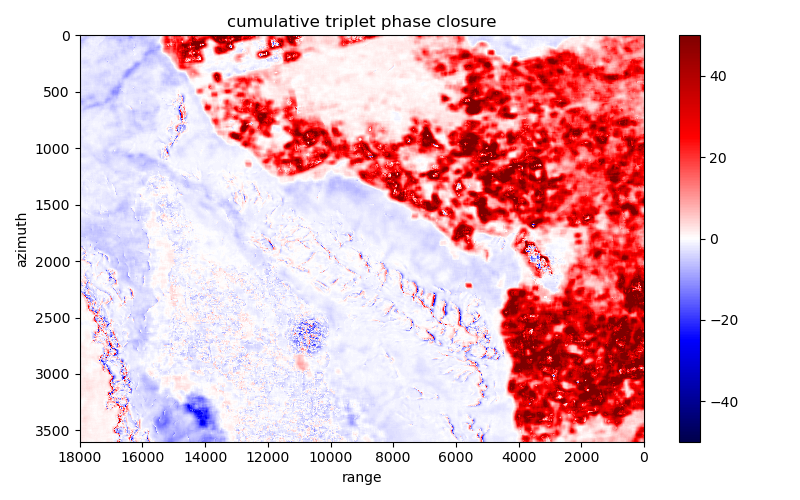

In [4]:
#plot cumulative tpc for entire region over entire time period
fig= plt.subplots(1,1,figsize=(8,5), tight_layout=True)
plt.subplot(1,1,1)
plt.imshow(tpcCum, vmin=-50, vmax=50, cmap='seismic', aspect='auto', \
                interpolation='nearest', extent = [x1,x2,y2,y1])
# can add vmin=-20, vmax=20, to above line of code 
plt.ylabel('azimuth')
plt.xlabel('range')
plt.colorbar()
plt.title("cumulative triplet phase closure")
plt.xlim([x2,x1])
plt.ylim([y2,y1])
plt.show()

plt.savefig('cum_tpc.png',transparent=True)

<br> Now do a skip2 analysis and compare to the sequential one above. <br> <br>

In [9]:
# initialize array to hold cumulative TPC values 
tpcCumSkip2 = np.zeros((dy,dx),'float')

# now calculate TPC for each triplet and add it to the cumulative TPC variable/array
filenames = []
for i in np.arange(nd-4): # the two on either end can't be calculated 
    # load in the 3 SLCs 
    ds = gdal.Open(workdir+"/"+cropdir+"/SLC_vv/"+dates[i]+"/"+dates[i]+".slc.full", \
                gdal.GA_ReadOnly)
    slc1 = ds.GetRasterBand(1).ReadAsArray(x1,y1,dx,dy)
    ds = gdal.Open(workdir+"/"+cropdir+"/SLC_vv/"+dates[i+2]+"/"+dates[i+2]+".slc.full", \
                gdal.GA_ReadOnly)
    slc2 = ds.GetRasterBand(1).ReadAsArray(x1,y1,dx,dy)
    ds = gdal.Open(workdir+"/"+cropdir+"/SLC_vv/"+dates[i+4]+"/"+dates[i+4]+".slc.full", \
                gdal.GA_ReadOnly)
    slc3 = ds.GetRasterBand(1).ReadAsArray(x1,y1,dx,dy)
    # 3 SLCs, can make 2 sequential igrams
    int12 = slc1 * np.conj(slc2)
    int23 = slc2 * np.conj(slc3)
    int31 = slc3 * np.conj(slc1)
    # normalizing, didn't change anything 
    int12 = np.exp(1j*np.angle(int12))
    int23 = np.exp(1j*np.angle(int23))
    int31 = np.exp(1j*np.angle(int31))
    # now filter them by alooks/rlooks 
    alooks=40; rlooks=200
    int12filt = uniform_filter((int12), size=[alooks,rlooks])
    int23filt = uniform_filter((int23), size=[alooks,rlooks])
    int31filt = uniform_filter((int31), size=[alooks,rlooks])
    # calculate tpc
    tpc = np.angle(int12filt*int23filt*int31filt)
    tpcCumSkip2 += tpc
    print('triplet '+str(i)+' complete')

triplet 0 complete
triplet 1 complete
triplet 2 complete
triplet 3 complete
triplet 4 complete
triplet 5 complete
triplet 6 complete
triplet 7 complete
triplet 8 complete
triplet 9 complete
triplet 10 complete
triplet 11 complete
triplet 12 complete
triplet 13 complete
triplet 14 complete
triplet 15 complete
triplet 16 complete
triplet 17 complete
triplet 18 complete
triplet 19 complete
triplet 20 complete
triplet 21 complete
triplet 22 complete
triplet 23 complete
triplet 24 complete
triplet 25 complete
triplet 26 complete
triplet 27 complete
triplet 28 complete
triplet 29 complete
triplet 30 complete
triplet 31 complete
triplet 32 complete
triplet 33 complete
triplet 34 complete
triplet 35 complete
triplet 36 complete
triplet 37 complete
triplet 38 complete
triplet 39 complete
triplet 40 complete
triplet 41 complete
triplet 42 complete
triplet 43 complete
triplet 44 complete
triplet 45 complete
triplet 46 complete
triplet 47 complete
triplet 48 complete
triplet 49 complete
triplet 50

In [ ]:
# save tpcCum to a file so I can not have to recalculate it each time 
# make it a file that ISCE can read 
driver=gdal.GetDriverByName('ISCE')
colds = driver.Create(workdir+'cumulative_tpc_skip2.r4',np.shape(tpc)[1],np.shape(tpc)[0],1,gdal.GDT_Float32)
colds.GetRasterBand(1).WriteArray(tpcCumSkip2)
# erase what was in colds so it's not saved to memory 
colds=None

In [6]:
# load in the file to plot if I haven't run the above code this session
f1 = gdal.Open(workdir+'cumulative_tpc_skip2.r4', gdal.GA_ReadOnly)
tpcCumSkip2 = f1.ReadAsArray()

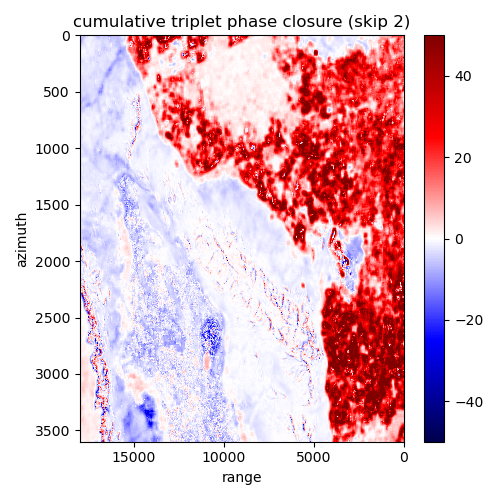

In [8]:
#plot cumulative tpc for entire region over entire time period
fig= plt.subplots(1,1,figsize=(5, 5), tight_layout=True)
plt.subplot(1,1,1)
plt.imshow(tpcCumSkip2, vmin=-50, vmax=50, cmap='seismic', aspect='auto', \
                interpolation='nearest', extent = [x1,x2,y2,y1])
# can add vmin=-20, vmax=20, to above line of code 
plt.ylabel('azimuth')
plt.xlabel('range')
plt.colorbar()
plt.title("cumulative triplet phase closure (skip 2)")
plt.xlim([x2,x1])
plt.ylim([y2,y1])
plt.show()

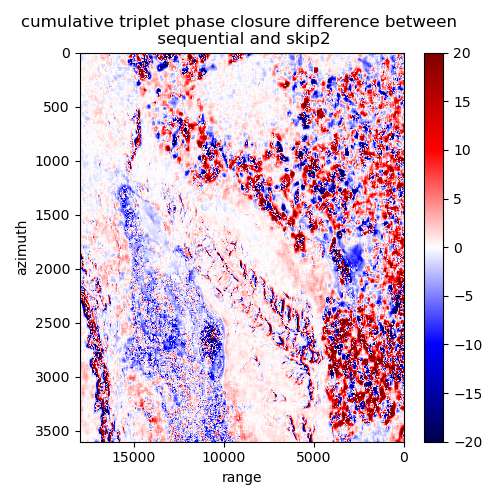

In [14]:
# try subtracting them from one another to see how much extra cumulative TPC was added by skipping 2 
# instead of using sequential pairs 

# calculate the difference 
CumTPCdiff = tpcCumSkip2 - tpcCum

#plot cumulative tpc for entire region over entire time period
fig= plt.subplots(1,1,figsize=(5, 5), tight_layout=True)
plt.subplot(1,1,1)
plt.imshow(CumTPCdiff, vmin=-20, vmax=20, cmap='seismic', aspect='auto', \
                interpolation='nearest', extent = [x1,x2,y2,y1])
# can add vmin=?, vmax=?, to above line of code 
plt.ylabel('azimuth')
plt.xlabel('range')
plt.colorbar()
plt.title("cumulative triplet phase closure difference between \n sequential and skip2")
plt.xlim([x2,x1])
plt.ylim([y2,y1])
plt.show()